In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error, mean_absolute_percentage_error

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

loading dataset

In [4]:
# Load dataset

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/DataSets/HousePriceData2017.xlsx'
df = pd.read_excel(file_path,sheet_name='2017')

print(df.shape)
df.head()

Mounted at /content/drive
(2974, 23)


,id,Date,number of bedrooms,number of bathrooms,living area,lot area,number of floors,waterfront present,number of views,condition of the house,...,Built Year,Renovation Year,Postal Code,Lattitude,Longitude,living_area_renov,lot_area_renov,Number of schools nearby,Distance from the airport,Price
0,6762814389,2017-01-05,9,3.00,3680,4400,2.0,0,0,3,...,1908,0,122013,52.8674,-114.514,1960,2450,2,75,700000
1,6762811858,2017-03-12,9,3.00,2820,4480,2.0,0,0,3,...,1918,0,122004,52.8954,-114.497,2460,4400,1,60,934000
2,6762824003,2017-02-18,8,3.00,2850,12714,1.0,0,0,3,...,1959,0,122042,52.7159,-114.395,1480,4942,2,56,373000
3,6762822117,2017-01-04,7,3.00,2940,8624,1.0,0,0,3,...,1977,0,122014,52.9855,-114.497,1850,8031,2,66,420000
4,6762812198,2017-01-14,7,4.75,5370,10800,1.5,0,0,3,...,1967,0,122057,52.7680,-114.413,2310,10910,1,58,884900


  Data preparation آماده‌سازی داده
 =============================


In [5]:
# Unnecessary columns elimination حذف ستون‌های غیرضروری
df = df.drop(columns=["id"])
df["year_sold"] = df["Date"].dt.year
df["month_sold"] = df["Date"].dt.month
df = df.drop(columns=["Date"])

# Built Year feature improvement   بهبود ویژگی‌های سال ساخت
current_year = df["year_sold"].max()
df["house_age"] = current_year - df["Built Year"]
df["renovated"] = (df["Renovation Year"] != 0).astype(int)
df = df.drop(columns=["Built Year", "Renovation Year"])

print("Columns:", df.columns.tolist())
target_candidates = [c for c in df.columns if "price" in c.lower()]
y = df[target_candidates[0]]
X = df.drop(columns=[target_candidates[0]])

df.head()

Columns: ['number of bedrooms', 'number of bathrooms', 'living area', 'lot area', 'number of floors', 'waterfront present', 'number of views', 'condition of the house', 'grade of the house', 'Area of the house(excluding basement)', 'Area of the basement', 'Postal Code', 'Lattitude', 'Longitude', 'living_area_renov', 'lot_area_renov', 'Number of schools nearby', 'Distance from the airport', 'Price', 'year_sold', 'month_sold', 'house_age', 'renovated']


,number of bedrooms,number of bathrooms,living area,lot area,number of floors,waterfront present,number of views,condition of the house,grade of the house,Area of the house(excluding basement),...,Longitude,living_area_renov,lot_area_renov,Number of schools nearby,Distance from the airport,Price,year_sold,month_sold,house_age,renovated
0,9,3.00,3680,4400,2.0,0,0,3,7,2830,...,-114.514,1960,2450,2,75,700000,2017,1,109,0
1,9,3.00,2820,4480,2.0,0,0,3,7,1880,...,-114.497,2460,4400,1,60,934000,2017,3,99,0
2,8,3.00,2850,12714,1.0,0,0,3,7,2850,...,-114.395,1480,4942,2,56,373000,2017,2,58,0
3,7,3.00,2940,8624,1.0,0,0,3,8,1690,...,-114.497,1850,8031,2,66,420000,2017,1,40,0
4,7,4.75,5370,10800,1.5,0,0,3,8,5370,...,-114.413,2310,10910,1,58,884900,2017,1,50,0


making Preprocessor
=============================

In [6]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])



**Models**

In [7]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42, n_estimators=200),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "SVM": SVC(kernel="rbf"),
    "MLP": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

**Feature strategies**

In [8]:
strategies  = {
    "All Features": preprocessor,  # حالت عادی

    "Top10 Correlation": ColumnTransformer(transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]),  # انتخاب 10 فیچر برتر بعداً

    "Top10 Importance": ColumnTransformer(transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]),  # انتخاب فیچر با importance

    "PCA (10)": Pipeline([
        ("preprocessor", preprocessor),
        ("pca", PCA(n_components=10))
    ])
}

**spliting dataset to train and test parts**

 تقسیم داده‌ها

In [9]:
# Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

**Training and Comparision**

In [10]:
results = []

for strat_name, strat in strategies.items():
    for model_name, model in models.items():

        # Special handling for Correlation
        if strat_name == "Top10 Correlation":

            corr = df.corr(numeric_only=True)[target_candidates[0]].abs().sort_values(ascending=False)
            top10 = corr.index[1:11].tolist()  # exclude price itself

            X_train_sel, X_test_sel = X_train[top10], X_test[top10]

            pipe = Pipeline(steps=[("scaler", StandardScaler()), ("model", model)])
            pipe.fit(X_train_sel, y_train)
            y_pred = pipe.predict(X_test_sel)

        # Special handling for Importance
        elif strat_name == "Top10 Importance":
            rf = RandomForestRegressor(n_estimators=200, random_state=42)
            rf.fit(X_train.select_dtypes(include=[np.number]), y_train)
            importances = pd.Series(rf.feature_importances_, index=X_train.select_dtypes(include=[np.number]).columns)
            top10 = importances.sort_values(ascending=False).head(10).index.tolist()
            X_train_sel, X_test_sel = X_train[top10], X_test[top10]
            pipe = Pipeline(steps=[("scaler", StandardScaler()), ("model", model)])
            pipe.fit(X_train_sel, y_train)
            y_pred = pipe.predict(X_test_sel)

        # PCA already included preprocessing
        elif strat_name == "PCA (10)":
            pipe = Pipeline(steps=[("preprocessor+pca", strat), ("model", model)])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)

        # Normal case
        else:
            pipe = Pipeline(steps=[("preprocessor", strat), ("model", model)])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)

        # Metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results.append({
            "Strategy": strat_name,
            "Model": model_name,
            "R2": r2,
            "MAE": mae,
            "RMSE": rmse
        })

results_df = pd.DataFrame(results)
print(results_df)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


             Strategy             Model        R2            MAE  \
0        All Features  LinearRegression  0.710060  126006.026048   
1        All Features      RandomForest  0.837917   82383.842613   
2        All Features  GradientBoosting  0.864498   79158.054336   
3        All Features               SVM  0.137318  170608.593277   
4        All Features               MLP  0.667118  142750.886142   
5   Top10 Correlation  LinearRegression  0.677570  134131.420064   
6   Top10 Correlation      RandomForest  0.767971   98005.217308   
7   Top10 Correlation  GradientBoosting  0.774637   98146.038617   
8   Top10 Correlation               SVM  0.310299  152271.937815   
9   Top10 Correlation               MLP  0.566701  165288.705349   
10   Top10 Importance  LinearRegression  0.694458  129683.084967   
11   Top10 Importance      RandomForest  0.831992   84368.919136   
12   Top10 Importance  GradientBoosting  0.831708   84784.653357   
13   Top10 Importance               SVM  0.33242

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


**Visualization**

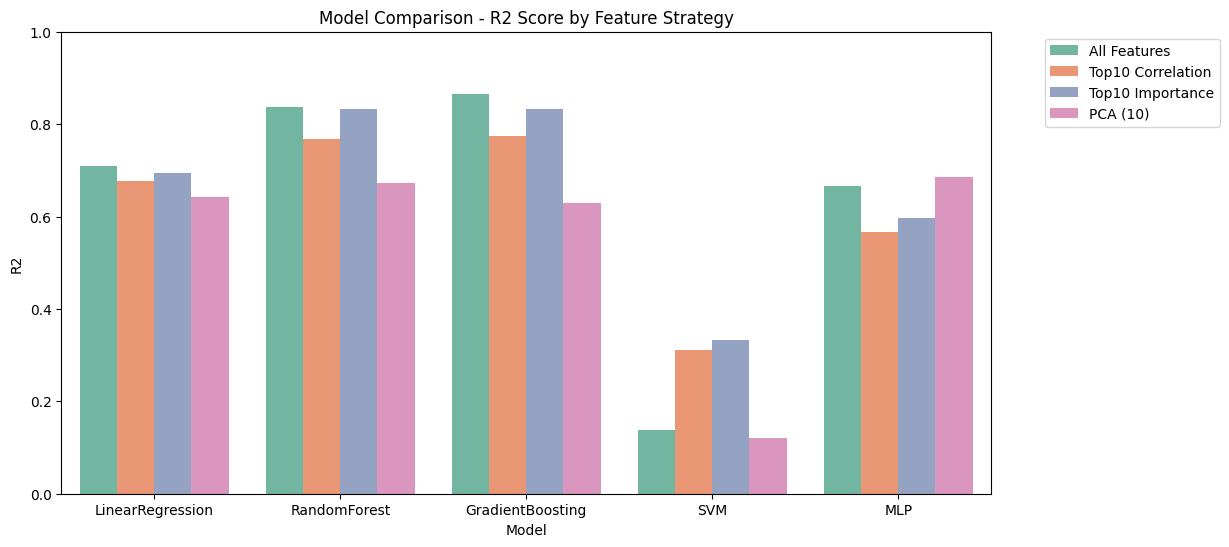

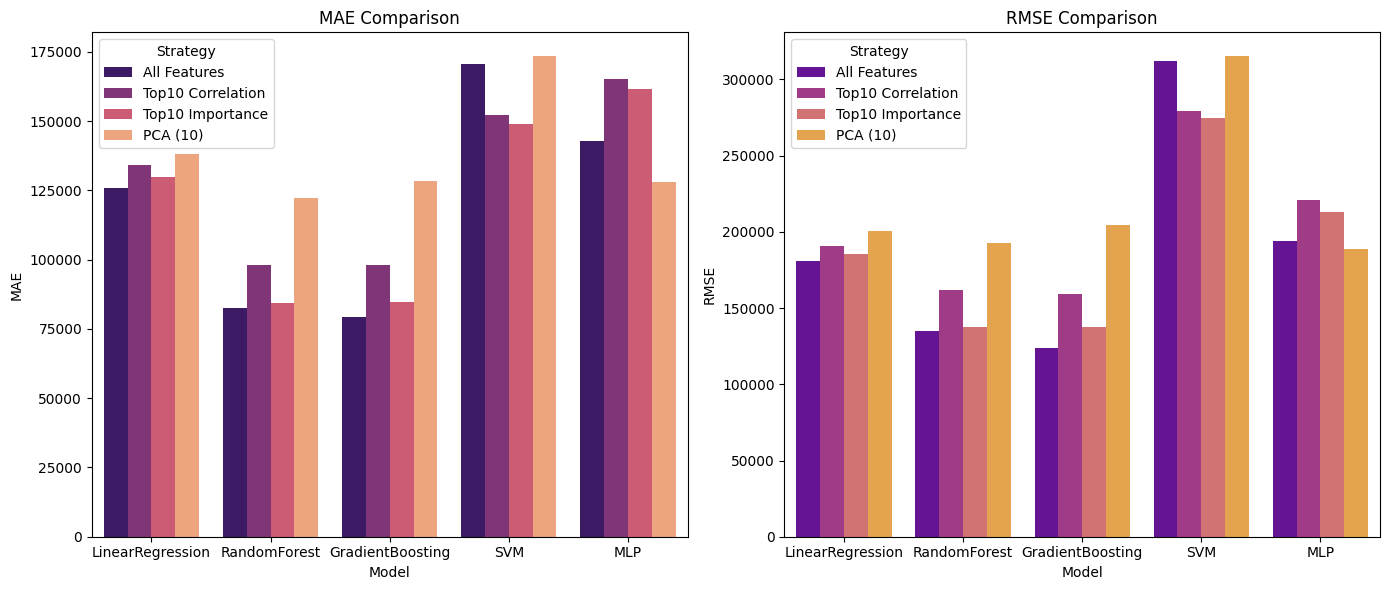

In [11]:
plt.figure(figsize=(12,6))
sns.barplot(data=results_df, x="Model", y="R2", hue="Strategy", palette="Set2")
plt.title("Model Comparison - R2 Score by Feature Strategy")
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.barplot(data=results_df, x="Model", y="MAE", hue="Strategy", ax=axes[0], palette="magma")
axes[0].set_title("MAE Comparison")
sns.barplot(data=results_df, x="Model", y="RMSE", hue="Strategy", ax=axes[1], palette="plasma")
axes[1].set_title("RMSE Comparison")
plt.tight_layout()
plt.show()

**Comparison charts**

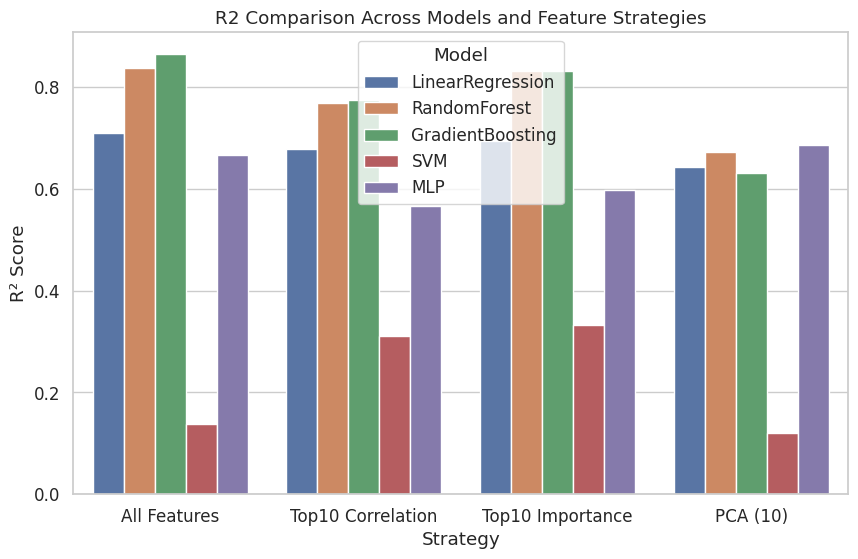

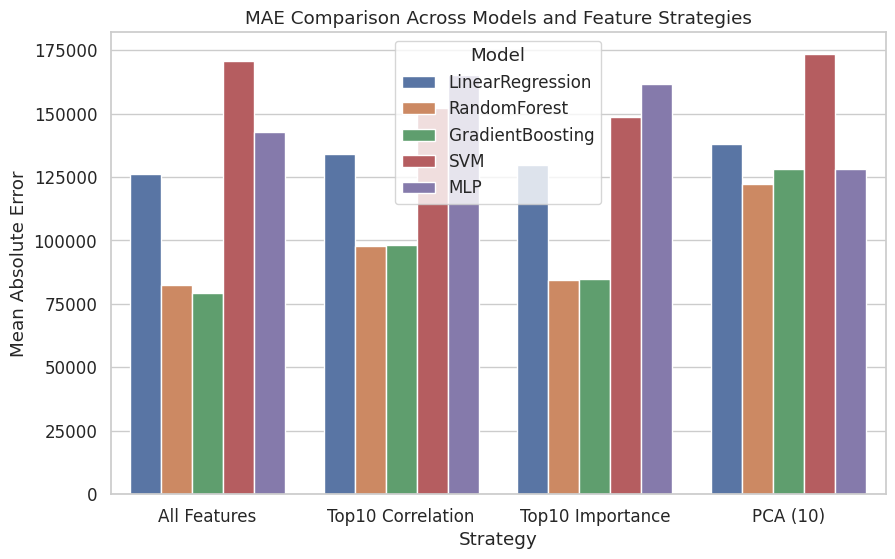

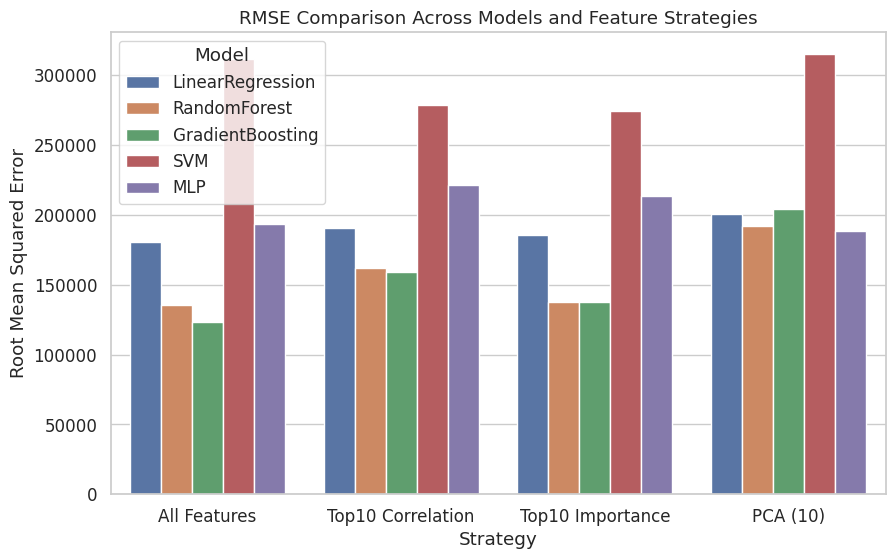

In [15]:
# Graphic style
sns.set(style="whitegrid", font_scale=1.1)

# R2 chart
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="Strategy", y="R2", hue="Model")
plt.title("R2 Comparison Across Models and Feature Strategies")
plt.ylabel("R² Score")
plt.legend(title="Model")
plt.show()

# MAE chart
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="Strategy", y="MAE", hue="Model")
plt.title("MAE Comparison Across Models and Feature Strategies")
plt.ylabel("Mean Absolute Error")
plt.legend(title="Model")
plt.show()

# RMSE chart
plt.figure(figsize=(10,6))
sns.barplot(data=results_df, x="Strategy", y="RMSE", hue="Model")
plt.title("RMSE Comparison Across Models and Feature Strategies")
plt.ylabel("Root Mean Squared Error")
plt.legend(title="Model")
plt.show()